In [1]:
cd /home

/home


In [2]:
import pandas as pd 

import matplotlib.pyplot as plt

import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

from src.data import pretraining_pipeline

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## RECORDS

In [177]:
data = pretraining_pipeline('./data/records/macho/train/',
                    batch_size=2000,
                    window_size=100,
                    msk_frac=0.,
                    rnd_frac=0.2,
                    same_frac=0.,
                    sampling=True,
                    shuffle=True,
                    repeat=1,
                    normalize='minmax',
                    cache=True)

[INFO] Repeating dataset x1 times
[INFO] Sampling random windows


2023-04-17 13:55:55.347032: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


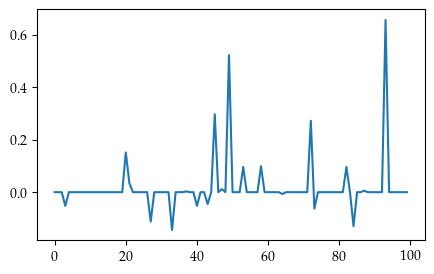

In [179]:
plt.figure(figsize=(5, 3))
for x, y in data.take(1):
    plt.plot(x['input'][0] - y['target'][0])
plt.show()

## RAW DATA

In [11]:
folder_dataset = './data/raw_data/alcock/'
metadata = pd.read_csv(os.path.join(folder_dataset, 'metadata.csv'))

In [4]:
metadata['Class'].value_counts()

RRab     7397
EC       6824
LPV      3046
RRc      1762
Cep_0    1182
Cep_1     683
UNK       550
Name: Class, dtype: int64

LPV
Cep_0
RRab
RRc
EC
UNK
Cep_1


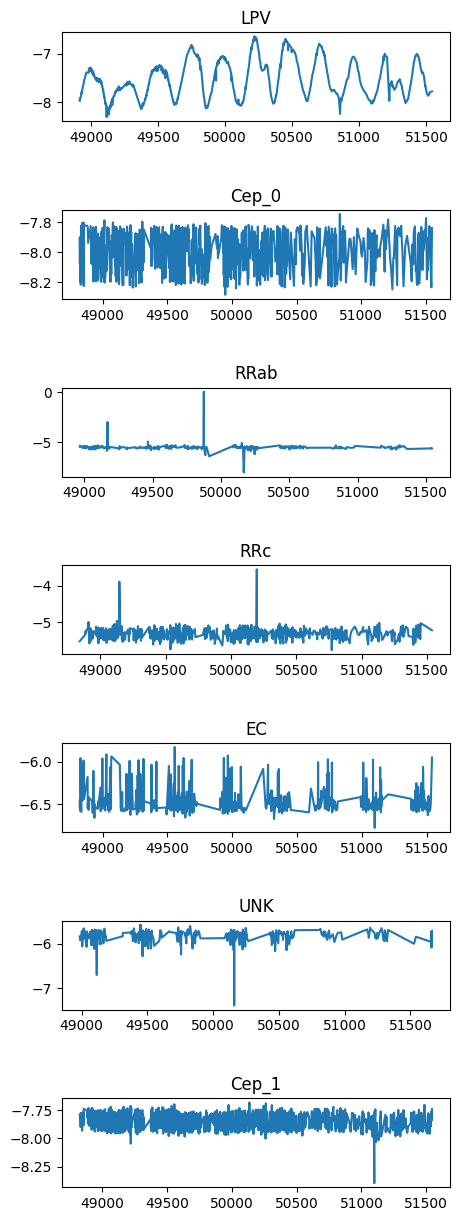

In [5]:
fig, axes = plt.subplots(len(metadata['Class'].unique()),1, figsize=(5,15), gridspec_kw={'hspace': 1, 'wspace': 0.2})

for i, name in enumerate(metadata['Class'].unique()):
    print(name)
    partial_meta = metadata[metadata['Class'] == name]
    sample_id = partial_meta.sample()['Path'].values[0]
    sample = pd.read_csv(os.path.join(folder_dataset, 'LCs', '{}'.format(sample_id)), 
                        )#delim_whitespace=True, 
                #names=['mjd', 'mag', 'err'])
    sample = sample.sort_values('mjd')
    axes[i].plot(sample['mjd'], sample['mag'])
    axes[i].set_title(name)

Text(0, 0.5, 'Magnitude')

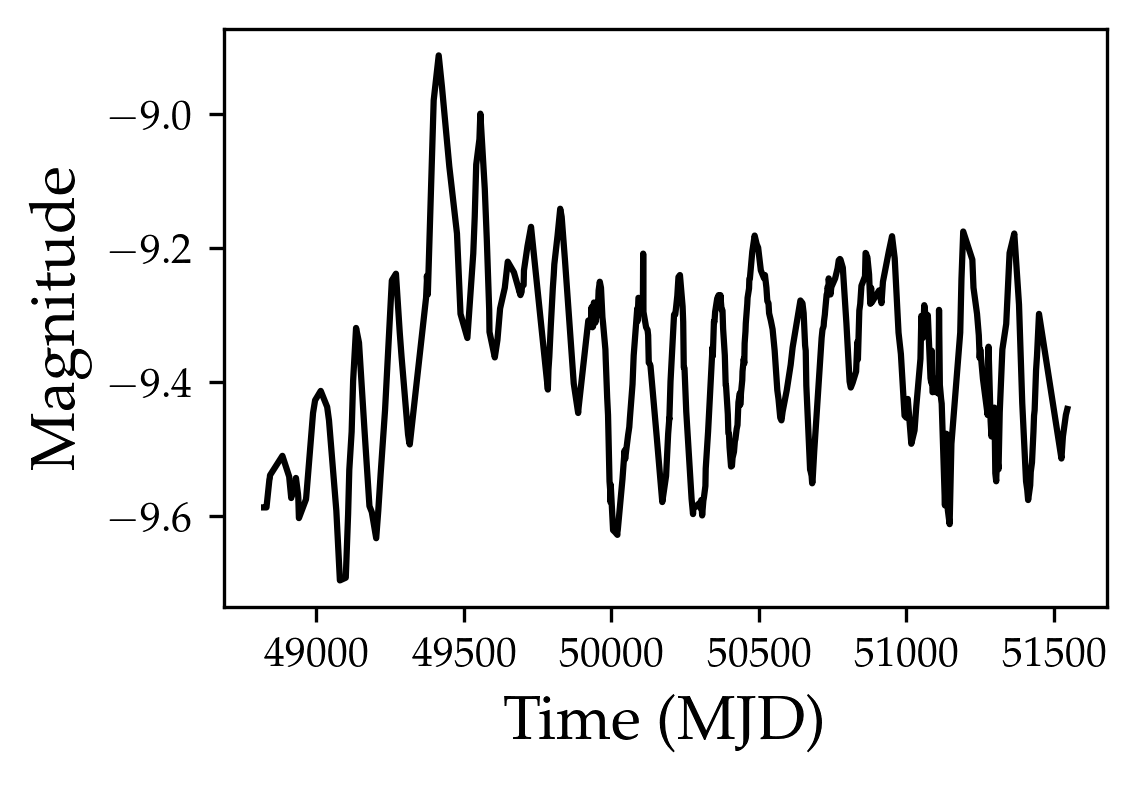

In [24]:
name = 'LPV'
partial_meta = metadata[metadata['Class'] == name]
sample_id = partial_meta.sample()['Path'].values[0]
sample = pd.read_csv(os.path.join(folder_dataset, 'LCs', '{}'.format(sample_id)), 
                    )#delim_whitespace=True, 
            #names=['mjd', 'mag', 'err'])
sample = sample.sort_values('mjd')
plt.figure(figsize=(3.8,2.5), dpi=300)
plt.plot(sample['mjd'], sample['mag'], color='k')
plt.xlabel('Time (MJD)', fontsize=15)
plt.ylabel('Magnitude', fontsize=15)
# plt.title('{} example'.format(name))

In [6]:
from src.data import pretraining_pipeline

data = pretraining_pipeline('./data/records/macho/train/',
                    batch_size=2000,
                    window_size=200,
                    msk_frac=0,
                    rnd_frac=0.,
                    same_frac=0.,
                    sampling=True,
                    shuffle=True,
                    repeat=1,
                    normalize='minmax',
                    cache=True)

[INFO] Repeating dataset x1 times
[INFO] Sampling random windows


In [7]:
import numpy as np

2023-04-12 13:00:27.408938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


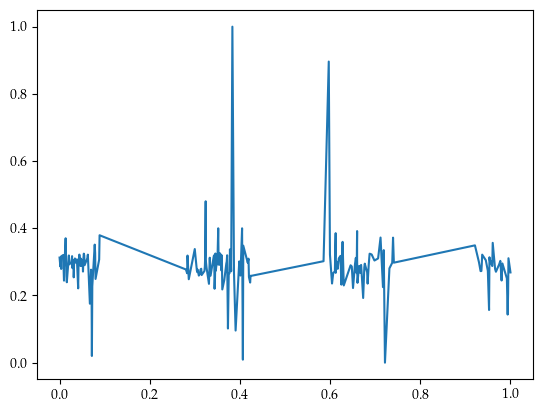

In [8]:
for x, _ in data.take(1):
    
    plt.plot(x['times'][0], x['input'][0])
    break